# 3DFlex Flow Generator
This project is submitted to fullfill the course requirement of Math 612D Topics in Mathematical Biology, Department of Mathematics, UBC.

Authorship: Shikun Nie

Email: kennethnye@math.ubc.ca

Any comments or questions are welcome and please direct them to the email address above.


## Revisions and comments for the Final Version Submission

1. The reference paper mentioned that kernels with finite support are used and it is critical to use high-order (e.g. tricubic) interpolation kernel. As a start to prove the concept, I used a simple averaging kernel. In the final version, I added a Gaussian kernel too. So, there should be no difficulty if a library of kernels are added to this project in future. 
2. An example of non-rigid flow is added with rigidity 0.344 per singular value so as to compare with a rigid flow with rigidity 0.0191 per singular value.
3. Time complexity analysis is carried out on mesh size and the number of voxels. It is clear that mesh size contributes little on the total time consumed while the number of voxels affect heavily. The time complexity of $N$ is approximately $O(N^{4.5})$
4. The "for loop" for associating each voxel with the correct tetrahedral element is improved in performance reducing running time by 10-fold. This is achieved by deleting the voxel once it is assigned to a tetrahedral element.  
5. Almost all codes are modularized into standalone functions such that they can be repeatedly called. 
6. The reference paper used protein density data obtained from consensus Cryo-EM experiments. However, in this project, to prove the concept, I utilized the voxel representation of 3D density map from python libary matplotlib. The reference paper only mentioned that finite element methods are used for interpolation to generate the flow fields. However, the details on constructing shape functions, associating each voxel with each tetrahedral elements and interpolating at each voxels are figured out in this project. Interpolating kernels are not explicitly defined in the reference paper, the simple kernel and the gaussian kernels are implemented according to my own interpretation. The relation between the shape function matrix and the corresponding affine transformation matrix are not mentioned in the reference paper, this has been worked out reducing the difficulties calculating the rigidity of the flow fields.   

April 29, 2022


## Introduction
This python code is a realization of the flow generator reported in the paper: *3D Flexible Refinement: Structure and Motion of Flexible Proteins from Cryo-EM*.

The full papaer is retrievable through: https://www.biorxiv.org/content/10.1101/2021.04.22.440893v1

Packages required to run this python code: [`meshpy, numpy, matplotlib, mpl_toolkits`](#code)


## Tetrahedral Mesh in a Cube $[0,1]^3$

A unit cube with vertices $(0,0,0), (1,0,0), (1,1,0), (0,1,0), (0,0,1), (1,0,1), (1,1,1), (0,1,1)$ is meshed into tetrahedral elements. 

In [1]:
from meshpy.tet import MeshInfo, build
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def unit_cubic_mesh(max_volume):
    mesh_info = MeshInfo()

    # create a mesh on a cube [0,1]^3 by specifying the eight vertex coordinates and the six facets.
    mesh_info.set_points([
        (0,0,0), (1,0,0), (1,1,0), (0,1,0),
        (0,0,1), (1,0,1), (1,1,1), (0,1,1),
        ])
    mesh_info.set_facets([
        [0,1,2,3],
        [4,5,6,7],
        [0,4,5,1],
        [1,5,6,2],
        [2,6,7,3],
        [3,7,4,0],
        ])
        
    # max-volume sets the maximum volume of each small tetrahedron element.
    mesh = build(mesh_info, max_volume = max_volume)

    # mesh data can be output as a paraview readable file. Use code: 
    # mesh.write_vtk("test.vtk")

    E, P = np.array(mesh.elements), np.array(mesh.points)

    # Option to print out the mesh points and elements. Use code: 
    # print ("Mesh Points:")
    # for i, p in enumerate(P):
    #    print (i, p)
    # print ("Point numbers in tetrahedra:")
    # for i, t in enumerate(E):
    #     print (i, t)

    # Filter out the unique pairs of edges before drawing 
    pairs1 = np.r_[E[:,[0,1]],E[:,[1,2]],E[:,[2,3]],E[:,[3,0]],E[:,[0,2]],E[:,[1,3]]]
    for i, pair in enumerate(pairs1):
        if pair[0] > pair[1]:
            pairs1[i,0],pairs1[i,1] = pairs1[i,1], pairs1[i,0]
    pairs2 = np.unique(pairs1, axis = 0)

    # Form the line segments
    segments = P[pairs2]

    ax = plt.figure().add_subplot(projection='3d')
    # draw the vertices of each tetrahedral elements
    ax.scatter(P[:,0],P[:,1],P[:,2], color = 'r', linewidths = 0.5)
    # draw the edges of all tetrahedral elements
    ax.add_collection3d(Line3DCollection(segments, colors='b', linewidths=0.5, linestyles='-'))
        
    plt.show()

    return E, P;

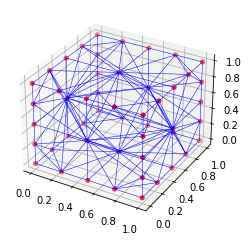

In [2]:
E, P = unit_cubic_mesh(0.1)

## 3D Density Map: Torus as the Domain. 
The domain of the density map is a torus,
$$ \{(x,y,z)\in \mathbb R^3:(R-\sqrt{(x-x_0)^2+(y-y_0)^2})^2+(z-z_0)^2 = r^2\} $$

where $(x_0,y_0,z_0)$ is the center of the torus,\
$r$ is the radius of the tube,\
and $R$ is the radius of the disc.

The density maps $V(x,y,z)$
$$V:\mathbb R^3 \to \mathbb R$$
$$(x,y,z)\mapsto \frac 1d \sqrt{(x-x_0)^2+(y-y_0)^2+(z-z_0)^2}$$
where $d$ is a scaling factor such that the output distance is alwasy in $[0,1]$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# find the midpoint coordinate of a 3D grid
def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

# set 'N' so that the number of voxels in a cube [0,1]^3 will be N^3.

def voxels_coordinates(N):
    # prepare the coordinates for each voxel
    X, Y, Z = np.indices((N + 1, N + 1, N + 1)) / N
    x = midpoints(X)
    y = midpoints(Y)
    z = midpoints(Z)
    return X,Y,Z,x,y,z;

def torus_density_map(X,Y,Z,x,y,z):

    # define the torus domain centred at (0.5, 0.5, 0.5) with R and r
    R = 0.3
    r = 0.15
    torus = (R - ((x -0.5) ** 2 + (y - 0.5) ** 2) ** (0.5)) ** 2 + (z - 0.5)**2 < r**2

    # denfine the density function 3D
    f = (2/3**(0.5))*((x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2)**(0.5)
    V = np.multiply(f, torus.astype(int))

    # assign density values to color scale in red
    colors = np.zeros(torus.shape + (3,))
    colors[..., 0] = V

    # If other RGB color scale is desired, use code:
    # colors[..., 1] = V
    # colors[..., 2] = V

    # plot the density map in the torus domain as voxel representation
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(X, Y, Z, torus,
            facecolors = colors,
            #edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
            edgecolors = 'k',
            linewidth = 0.5/N)
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    plt.show()
    return torus, V;

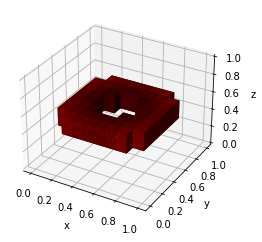

In [4]:
N = 10
X,Y,Z,x,y,z = voxels_coordinates(N)
torus, V = torus_density_map(X,Y,Z,x,y,z)

## Define the Map from Canonical Coordinates to Deformed Coordinate: an Example of Rigid Flow
$$u:\mathbb R^3 \to \mathbb R^3$$
$$ \mathbf{x}\mapsto u(\mathbf{x})$$
$$u(\mathbf{x}) = \frac {1}{N\sqrt {(x-0.9)^2+(y-0.5)^2+(z-0.5)^2}}(0.9-x,0.5-y,0.5-z) + (x,y,z) $$
where $N^3$ is the number of voxels in a cube.

In [5]:
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import matplotlib.pyplot as plt

def rigid_flow(P, N):
    # initialize u(x) - x and u(x)
    vectors = np.zeros(P.shape)
    fvectors = np.zeros(P.shape)

    vectors[:,0] = (1.0/N)*(0.9 - P[:,0])/((P[:,0] - 0.9)**2 + (P[:,1] - 0.5)**2 + (P[:,2] - 0.5)**2)**(0.5)
    vectors[:,1] = (1.0/N)*(0.5 - P[:,1])/((P[:,0] - 0.9)**2 + (P[:,1] - 0.5)**2 + (P[:,2] - 0.5)**2)**(0.5)
    vectors[:,2] = (1.0/N)*(0.5 - P[:,2])/((P[:,0] - 0.9)**2 + (P[:,1] - 0.5)**2 + (P[:,2] - 0.5)**2)**(0.5)

    # define the flow vectors fields
    fvectors = np.add(vectors, P)

    # only draw the flow vector fields on the vertices of tetrahedron, that is to say, u(x) - x    
    ax = plt.figure().add_subplot(projection='3d')
    ax.quiver(P[:,0],P[:,1],P[:,2], vectors[:,0], vectors[:,1], vectors[:,2], linewidth = 0.5, length = 0.3, color = 'red')

    plt.show()
    return fvectors

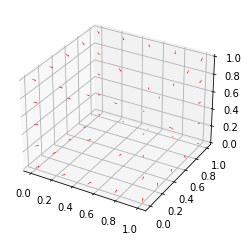

In [6]:
fvectors = rigid_flow(P, N)

## an Example of non-Rigid Flow

$$u:\mathbb R^3 \to \mathbb R^3$$

$$ \mathbf{x} \mapsto u(\mathbf{x})=\left\{
\begin{array}{ll}
      (0,0, 0.4) + (x,y,z) & x\le 0.5 \\
      (0,0, -0.4) + (x,y,z) & x\gt 0.5 \\
\end{array} 
\right.$$ 
where $N^3$ is the number of voxels in a cube.



In [7]:
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import matplotlib.pyplot as plt

def non_rigid_flow(P):
    # initialize u(x) - x and u(x)
    vectors = np.zeros(P.shape)
    fvectors = np.zeros(P.shape)

    vectors[:,0] = np.zeros((P.shape[0],))
    vectors[:,1] = np.zeros((P.shape[0],))
    vectors[:,2] = 0.4 * np.subtract(np.multiply(np.ones((P.shape[0],)), P[:,0] <= 0.5), np.multiply(np.ones((P.shape[0],)), P[:,0] > 0.5))

    # define the flow vectors fields
    fvectors = np.add(vectors, P)

    # only draw the flow vector fields on the vertices of tetrahedron, that is to say, u(x) - x    
    ax = plt.figure().add_subplot(projection='3d')
    ax.quiver(P[:,0],P[:,1],P[:,2], vectors[:,0], vectors[:,1], vectors[:,2], linewidth = 0.5, length = 0.3, color = 'red')

    plt.show()
    return fvectors

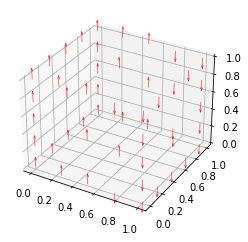

In [8]:
fvectors2 = non_rigid_flow(P)

## Associate Each Voxel with the Correct Tetrahedron Element

The following linear transformation takes a point in cartesian coordinates and converts it into a point in tetrahedral coordinates where the tetrahedon has vertices $(x_i,y_i,z_i), i = 1,2,3,4$

The tetrahedral coordinates are defined such that $(x_1, y_1, z_1)$ is the origin while $(x_2 - x_1, y_2 - y_1, z_2 - z_1)$ is $x$-axis with unit length, $(x_3 - x_1, y_3 - y_1, z_3 - z_1)$ is $y$-axis with unit length and $(x_4 - x_1, y_4 - y_1, z_4 - z_1)$ is $z$-axis with unit length. For example, if the input of $\varphi$ is $(x_2, y_2, z_2)$, the output will be $(1, 0, 0)$.

\begin{equation*}
\varphi(\mathbf x) =
\begin{pmatrix}
x_2-x_1 & x_3-x_1 & x_4-x_1\\
y_2-y_1 & y_3-y_1 & y_4-y_1\\
z_2-z_1 & z_3-z_1 & z_4-z_1\\
\end{pmatrix}
^{-1}
\begin{pmatrix}
x-x_1\\
y-y_1\\
z-z_1\\
\end{pmatrix}

\end{equation*}

If a point $(x,y,z) $ is inside or on the tetrahedron, its tetrahedral coordinates $(x',y',z')=\varphi(x,y,z)$ must satisfy the following inequalities:
$$x' + y' + z' \le 1$$
$$0 \le x' \le 1$$
$$0 \le y' \le 1$$
$$0 \le z' \le 1$$

These inequalites are used to check whether an arbitary voxel is inside or on the tetrahedron element.

In [9]:
import numpy as np 

def Tetrahedron(vertices):
    """
    Given a list of the xyz coordinates of the vertices of a tetrahedron, 
    return tetrahedron coordinate system
    """
    origin, *rest = vertices
    mat = (np.array(rest) - origin).T
    tetra = np.linalg.inv(mat)
    return tetra, origin

def pointInside(point, tetra, origin):
    """
    Takes a single point or array of points, as well as tetra and origin objects returned by 
    the Tetrahedron function.
    Returns a boolean or boolean array indicating whether the point is inside the tetrahedron.
    """
    newp = np.matmul(tetra, (point-origin).T).T
    return np.all(newp>=0, axis=-1) & np.all(newp <=1, axis=-1) & (np.sum(newp, axis=-1) <=1)

In [10]:
def associate_voxel_with_TetraE(x,y,z):

    voxels = np.array([np.reshape(x,(x.size,)), np.reshape(y,(y.size,)), np.reshape(z,(z.size,))]).T
    indices = np.zeros((voxels.shape[0],))

    # this for loop can be improved for time consumption by swaping enumerate(voxels) and enumerate(E).  

    # for i, points in enumerate(voxels):
    #     for j, vertices in enumerate(E):
    #         tetra, origin = Tetrahedron(P[vertices])
    #         inTet = pointInside(points, tetra, origin)
    #         if inTet == True:
    #             indices[i] = j       

    # This modified loop runs much faster. The loop runs while deleting the specific voxel once it is assignd to a tetrahadron.    
    ID = np.array(range(voxels.shape[0]))
    voxels_w_ID = np.c_[ID, voxels]

    for j, vertices in enumerate(E):
        tetra, origin = Tetrahedron(P[vertices])
        dlist = np.array([],dtype = int)
        for i, points in enumerate(voxels_w_ID):
            if pointInside(points[1:4], tetra, origin):
                indices[int(points[0])] = j
                dlist = np.append(dlist, i)
        # deleting those voxels which are already assigned to a tetrahedraon element. 
        voxels_w_ID = np.delete(voxels_w_ID, dlist,0)
    return voxels, indices

In [11]:
voxels, indices = associate_voxel_with_TetraE(x,y,z)

Time Complexity Analysis for function [`Tetrahedron()`](#code) and [`pointInside()`](#code). Ingnorable. 

In [182]:
import numpy as np
import time
# alternatively, import cupy as np if len(points)>1e7 and GPU
for i in 2**np.linspace(15,24,10,dtype = int):
    npt = i
    points = np.random.rand(npt,3)
    # Coordinates of vertices A, B, C and D
    A=np.array([0.1, 0.1, 0.1])
    B=np.array([0.9, 0.2, 0.1])
    C=np.array([0.1, 0.9, 0.2])
    D=np.array([0.3, 0.3, 0.9])
    start_time = time.time()
    vertices = [A, B, C, D]
    tetra, origin = Tetrahedron(vertices)
    inTet = pointInside(points, tetra, origin)
    print("number of points %s --- %s seconds ---" % (i, time.time() - start_time))
print("So it is of order big-O(n)")

number of points 32768 --- 0.0029964447021484375 seconds ---
number of points 65536 --- 0.005991697311401367 seconds ---
number of points 131072 --- 0.006002902984619141 seconds ---
number of points 262144 --- 0.016004085540771484 seconds ---
number of points 524288 --- 0.03200030326843262 seconds ---
number of points 1048576 --- 0.05500483512878418 seconds ---
number of points 2097152 --- 0.12899541854858398 seconds ---
number of points 4194304 --- 0.24900460243225098 seconds ---
number of points 8388608 --- 0.44101452827453613 seconds ---
number of points 16777216 --- 1.1432063579559326 seconds ---
So it is of order big-O(n)


Test code to validate function [`Tetrahedron()`](#code) and [`pointInside()`](#code). Ingnorable. 

In [183]:
import numpy as np
tetra, origin = Tetrahedron(np.array([[0,0,0],[1,0,0],[0,1,0],[0,0,1]]))
print(pointInside(np.array([1,1,1]),tetra,origin))
print(pointInside(np.array([0.1,0.1,0.1]),tetra,origin))

False
True


## Interpolating Flow Vector Fields at Each Voxel
Shape function for each tetrahedral element with vertices $(x_i, y_i, z_i), i = 1, 2, 3, 4$ and the corresponding flow vectors at each vertiex $(u_i, v_i, w_i)$ is defined as

$$
\phi : \mathbb R^3 \to \mathbb R^3
$$

$$
\mathbb x \mapsto
\phi(\mathbf x) = 
\begin{pmatrix}
u_1 & u_2 & u_3 & u_4 \\
v_1 & v_2 & v_3 & v_4 \\
w_1 & w_2 & w_3 & w_4  \\ 
\end{pmatrix}
\begin{pmatrix}
1 & 1 & 1 & 1 \\
x_1 & x_2 & x_3 & x_4 \\
y_1 & y_2 & y_3 & y_4  \\
z_1 & z_2 & z_3 & z_4 \\ 
\end{pmatrix}
^{-1}
\begin{pmatrix}
1 \\
x \\
y \\
z \\ 
\end{pmatrix}
$$

For each voxels inside or on the tetrahedral element, the shape function returns a linear combination of the four flow vectors at each vertex. This shape function can be easily written as an affine transformation. Denote 

$$
\phi(\mathbf x) 
=
\begin{pmatrix}
b_{1} & a_{11} & a_{12} & a_{13} \\
b_{2} & a_{21} & a_{22} & a_{23} \\
b_{3} & a_{31} & a_{32} & a_{33}  \\
\end{pmatrix}
\begin{pmatrix}
1 \\
x \\
y \\
z \\ 
\end{pmatrix} 
$$

Then, 

$$
\phi(\mathbf x) 
=
\begin{pmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33}  \\
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
z \\ 
\end{pmatrix}
+ 
\begin{pmatrix}
b_1 \\
b_2 \\
b_3 \\ 
\end{pmatrix}
$$

that is to say,

$$\phi (\mathbf x) = A\mathbf x +\mathbf b$$ 
where $A$ is a $3\times 3$ matrix and $b$ is a column vector of dimension $3$. 

Notice that the flow vector field $u(\mathbf x)$ is exactly $\phi(\mathbf x)$ restricted to each tetrahedral element. Denote $u_{ij}(\mathbf x)$ as the flow vector field of the $i$-th image at $j$-th tetrahedral element, we have
$$u_{ij}(\mathbf x)=A_{ij}\mathbf x + \mathbf b_{ij}$$


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# assemble the shape function matrix where M[i] is the shape function of the i-th tetrahedron element
def shape_function(P, E, vectors):
    M = np.zeros((E.shape[0], 3, 4))
    
    for i, elements in enumerate(E):
        M[i] = np.matmul(vectors[elements].T, np.linalg.inv(np.c_[np.ones((4,1)),P[elements]].T))
    return M

# interpolating the flow vector at each voxel point.
def interpolation(voxels, indices, M):
    voxels_v = np.zeros(voxels.shape)
    coordinates = np.c_[np.ones((voxels.shape[0],1)),voxels]
    for i, points in enumerate(coordinates):
        voxels_v[i] = np.matmul(M[int(indices[i])], points.T)
    return voxels_v

def flow_fields(voxels, indices, P, E, fvectors):
    # note that the interpolation is on u(x) and however we draw u(x) - x in the figure below.
    M = shape_function(P, E, fvectors)
    # u(x)
    voxels_v0 = interpolation(voxels, indices, M)
    # u(x)-x
    voxels_v = np.subtract(voxels_v0, voxels)
    # print(voxels_v)  

    # draw the flow vector fields at each voxel
    ax = plt.figure().add_subplot(projection='3d')
    ax.quiver(voxels[:,0], voxels[:,1], voxels[:,2], voxels_v[:,0], voxels_v[:,1], voxels_v[:,2], linewidth = 5/N, length=5/N, color = 'red')
    plt.show()
    return M, voxels_v0;

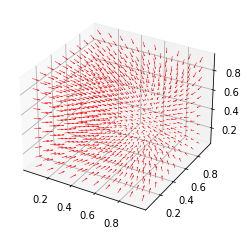

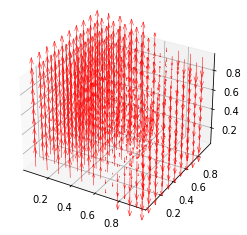

In [25]:
M0, voxels_v0 = flow_fields(voxels, indices, P, E, fvectors)
M1, voxels_v1 = flow_fields(voxels, indices, P, E, fvectors2)

## Define the Kernel Function: A simple nearest-neighbour averaging kernel
Suppose we have a 3D discrete density map $V(x,y,z)$, the convolution of $V$ with a kernel $k$ is defined as
$$W(x,y,z)=V(x,y,z)*k(x,y,z)=\sum_{i=0}^{l-1}\sum_{j=0}^{w-1}\sum_{k=0}^{h-1}V(i,j,k)k(x-i,y-j,z-k)$$
where the kernel is of $l$ length, $w$ width and $h$ height. 

The kernel function acts as smoothing. A simple kernel is defined as follows:  

$$k:\mathbb R^3 \to \mathbb R$$
$$ \mathbf{x} \mapsto \left\{
\begin{array}{ll}
      1 & \max (|x|, |y|, |z|) < \frac{1}{2N} \\
      0.1 & \frac{1}{2N}\le\max (|x|, |y|, |z|)<\frac{2}{3N} \\
      0 & \text{otherwise}
\end{array} 
\right.$$ 

where $\frac 1N$ is the side length of each voxel

In [19]:
import numpy as np

# define the simple kernel function
def kernel(points, N):
    d = max(np.absolute(points)) 
    d_max = 1.0/(2.0*N)
    if d < d_max:
        return 1
    elif d >= d_max and d < 1.5*d_max:
        return 0.1
    else:
        return 0
def simple(voxels, Nvoxels, V, N):
    W = np.zeros(V.shape)
    norm = np.zeros(V.shape)
    for i, point in enumerate(voxels):
    # Instead of searching for the entire list of Nvoxels, one can limit the search list to the surrounding points of i
        for j, Npoint in enumerate(Nvoxels):
            K = kernel(np.subtract(point,Npoint),N) 
            W[i] += K*V[j]
            norm[i] += K
        # avoid division by 0 error
        if norm[i] == 0:
            norm[i] = 1
    # Normalize the density such that the density is always between [0,1]
    return np.divide(W,norm)

## Alternative Kernel: the Gaussian Kernel

The Gaussian kernel is defined as 
$$k:\mathbb R^3 \to \mathbb R$$
$$ \mathbf{x} \mapsto \frac1{{(2\pi)}^{\frac32} \sigma^3} e ^{-\frac{|| \mathbf x|| _2^2}{2\sigma^2}}$$ 

In [20]:
import numpy as np
import math
# define the Gaussian kernel
def gaussian(voxels, Nvoxels, V, sigma):
    W = np.zeros(V.shape)
    norm = np.zeros(V.shape)
    for i, point in enumerate(voxels):
    # Instead of searching for the entire list of Nvoxels, one can limit the search list to the surrounding points of i
        for j, Npoint in enumerate(Nvoxels):
            K = (1/((sigma**3)*((2*math.pi)**1.5)))*math.exp(-sum(np.square(np.subtract(point,Npoint)))/(2.0*sigma**2.0))
            W[i] += K*V[j]
            norm[i] += K
        # avoid division by 0 error     
        if norm[i] == 0:
            norm[i] = 1 
    W = np.divide(W,norm)
    # the condition is set to clear background noise.
    return np.multiply(W, W > 0.05*np.max(W))

## Calculate the Deformed Density Map
From the reference paper, the deformed desnity map is defined below. Intuitively, the deformed density at each voxel is the "average" of the convected density from the canonical model by the kernel smoothing. 
$$W:\mathbb R^3\to \mathbb R^3$$
$$\mathbf{x}\mapsto \sum_\mathbf{y} k(\mathbf{x}-u(\mathbf{y}))V(\mathbf y)$$

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def deformed_density_map(X, Y, Z, torus, voxels_v0, V, kernel, N):
    # Nvoxels = np.add(voxels, voxels_v)
    Nvoxels = voxels_v0
    V1 = np.reshape(V,(1,-1)).T
    
    if kernel == 'simple':
        W1 = simple(voxels, Nvoxels, V1, N)
    elif kernel == 'gaussian':
        W1 = gaussian(voxels, Nvoxels, V1, 1/(3*N))

    colors = np.zeros(torus.shape + (3,))
    colors[..., 0] = np.reshape(W1, (N, N, N))
    # colors[..., 1] = V
    # colors[..., 2] = V

    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(X, Y, Z, colors[...,0] > 0,
            facecolors=colors,
            #edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
            edgecolors = 'k',
            linewidth=0.5/N)
    ax.set(xlabel='x', ylabel='y', zlabel='z')

    plt.show() 
    return W1

Deformed density map with rigid flow and simple kernel


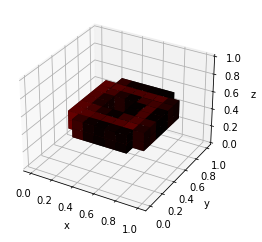

Deformed density map with rigid flow and gaussian kernel


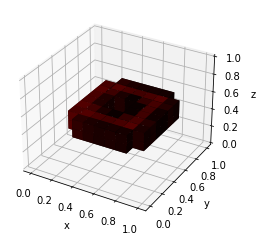

Deformed density map with non-rigid flow and simple kernel


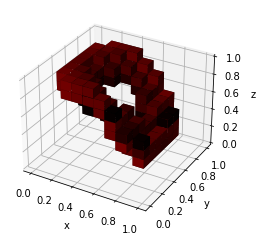

Deformed density map with non-rigid flow and gaussian kernel


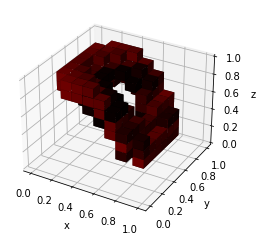

In [23]:
print("Deformed density map with rigid flow and simple kernel")
W1 = deformed_density_map(X, Y, Z, torus, voxels_v0, V, 'simple', N)
print("Deformed density map with rigid flow and gaussian kernel")
W2 = deformed_density_map(X, Y, Z, torus, voxels_v0, V, 'gaussian', N)
print("Deformed density map with non-rigid flow and simple kernel")
W3 = deformed_density_map(X, Y, Z, torus, voxels_v1, V, 'simple', N)
print("Deformed density map with non-rigid flow and gaussian kernel")
W4 = deformed_density_map(X, Y, Z, torus, voxels_v1, V, 'gaussian', N)

## Check rigidity of $u(\mathbf x)$
From the reference paper, the rigidity of $u(\mathbf x)_{ij}$ is defined as the sum of square deviation of singular values of $A_{ij}$ from unity. Denote 

$$u_{ij}(\mathbf x) = A_{ij}\mathbf x + b_{ij}$$

Assume the singular values of $A_{ij}$ are $s_{ij}^l, l = 1,2,3$ respectively. The the rigidity of $A_{ij}$ is defined as follows:
$$\sum_{l=1}^3 (s_{ij}^l-1)^2$$

In [33]:
import numpy.linalg as la

# return the rigidity of a 3 by 3 matrix
def rigidity(A):
    u, s, vh = la.svd(A)
    # return (s[0] - 1)**2 + (s[1] - 1)**2 + (s[2] - 1)**2
    return np.sum(np.square(s - np.ones(s.shape)))
    
# return the E_rigidity of a flow field u(x) with shape function M and weights w    
def E_rigidity(M, weights):
    N = M[:, :, 1:]
    E_r = 0
    for i, w in enumerate(weights):
        E_r += w*rigidity(N[i])
    print('Rigidity for the flow fields on current layer is')
    print(E_r)
    print('Average rigidity per singular value is')
    print(E_r/(3*M.shape[0]))    
    return E_r 

Tests to validate function [`rigidity()`](#code) and [`E_rigidity()`](#code). Ignorable

In [191]:

import numpy as np

A = np.array([[1.1,0,0],[0,1.1,0],[0,0,1.1]])
print(rigidity(A))

B = np.array([[1.2,0,0],[0,1.2,0],[0,0,1.2]])
print(rigidity(B))

Test = np.array([np.c_[np.ones((3,1)),A], np.c_[np.ones((3,1)),B]])
print(E_rigidity(Test, np.array([1,1])))


0.030000000000000054
0.11999999999999994
0.15


Rigidity of the flow vector fields at $i$-th image is a weighted sum of rigidity of each tetrahedral elements. While the total rigidity of the flow vector fields is the summation of rigidity of all images. That is to say, the total rigidity $E_{rigidity}$ can be expressed as 
$$E_{rigidity} = \sum_i \sum_j w_j \sum_{l=1}^{3}(s_{ij}^l - 1)^2$$

In [39]:
import numpy as np
print("Rigidity for the example of rigid flow:")
E_r0 = E_rigidity(M0, np.ones(M0.shape[0]))
print()
print()
print("Rigidity for the example of non-rigid flow:")
E_r1 = E_rigidity(M1, np.ones(M1.shape[0]))

Rigidity for the example of rigid flow:
Rigidity for the flow fields on current layer is
3.9052271747390233
Average rigidity per singular value is
0.019143270464406975


Rigidity for the example of non-rigid flow:
Rigidity for the flow fields on current layer is
70.21614817944578
Average rigidity per singular value is
0.3441968048012048


## Time complexity in terms of mesh size and number of voxels 

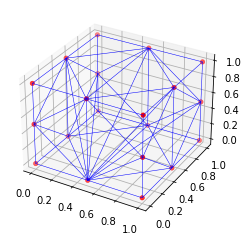

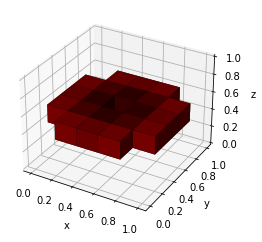

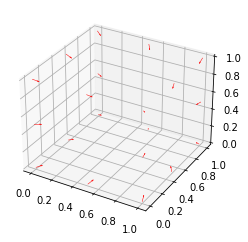

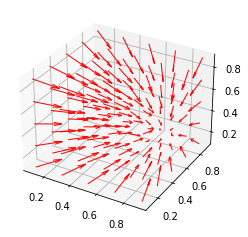

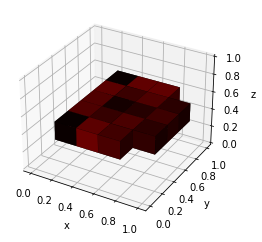

maximum_volume 0.2 and number of voxels 125 --- 1.0050394535064697 seconds ---


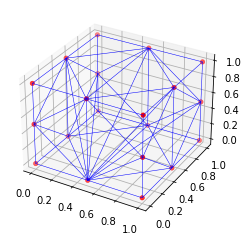

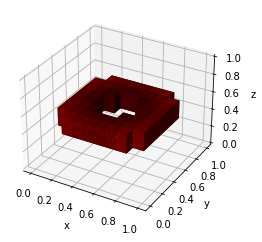

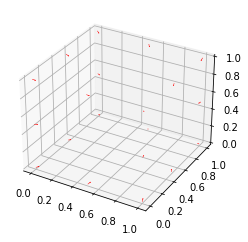

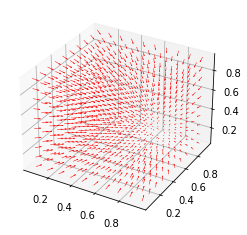

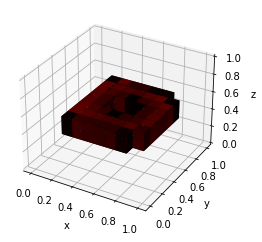

maximum_volume 0.2 and number of voxels 1000 --- 19.057207584381104 seconds ---


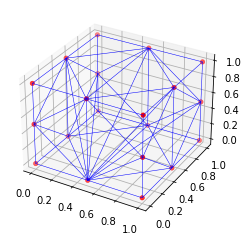

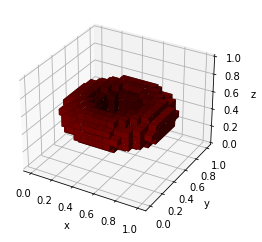

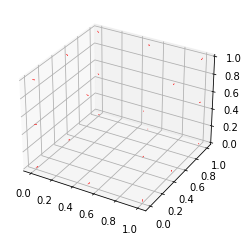

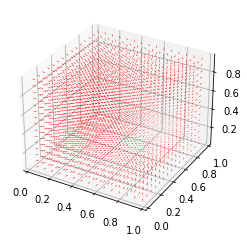

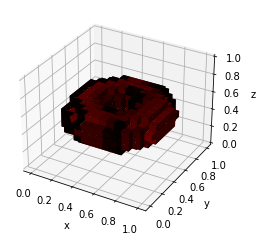

maximum_volume 0.2 and number of voxels 3375 --- 103.54718255996704 seconds ---


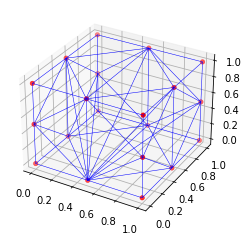

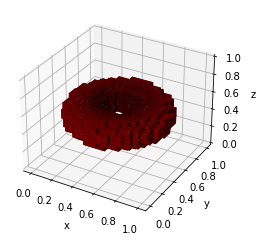

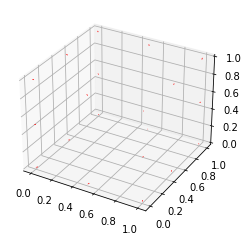

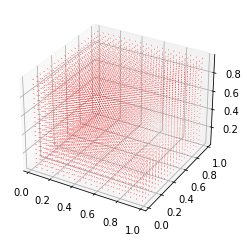

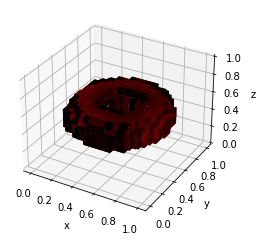

maximum_volume 0.2 and number of voxels 8000 --- 591.8393597602844 seconds ---


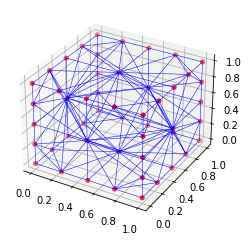

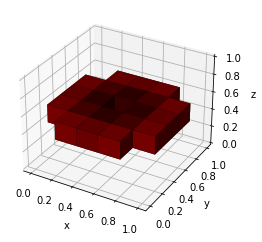

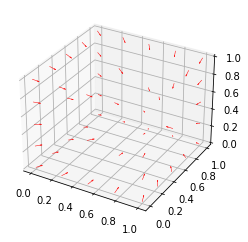

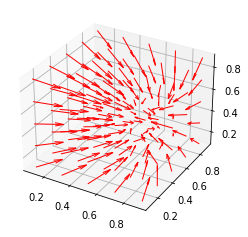

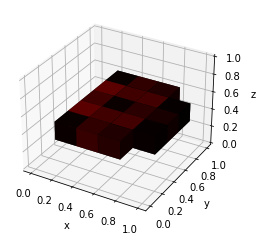

maximum_volume 0.1 and number of voxels 125 --- 1.292037010192871 seconds ---


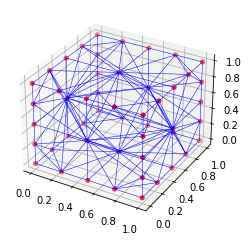

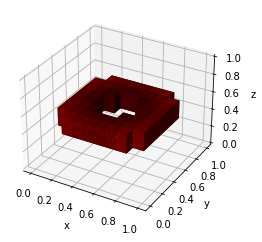

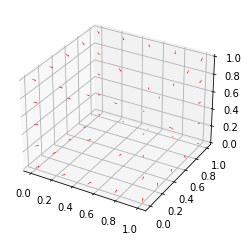

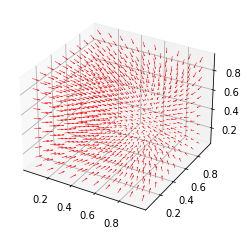

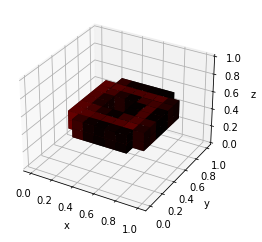

maximum_volume 0.1 and number of voxels 1000 --- 11.8662850856781 seconds ---


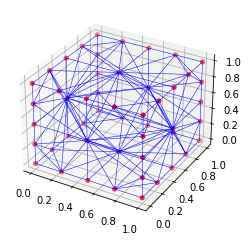

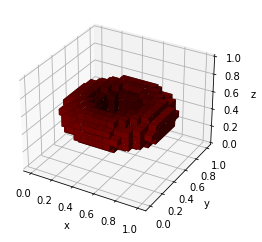

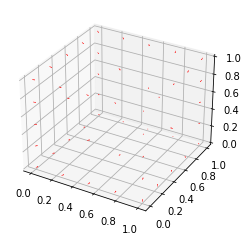

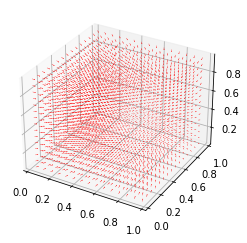

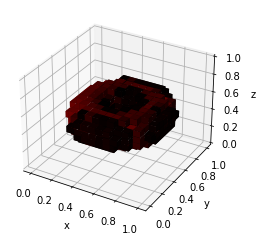

maximum_volume 0.1 and number of voxels 3375 --- 107.22441053390503 seconds ---


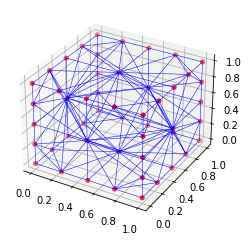

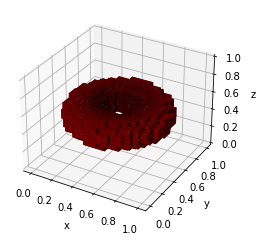

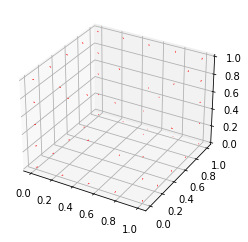

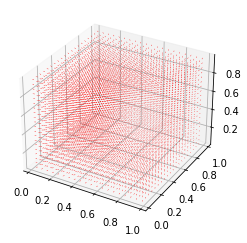

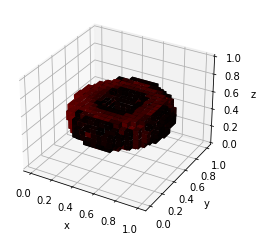

maximum_volume 0.1 and number of voxels 8000 --- 604.3113825321198 seconds ---


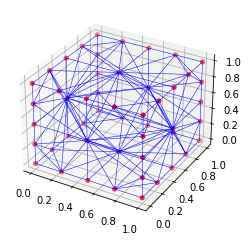

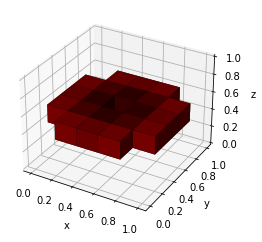

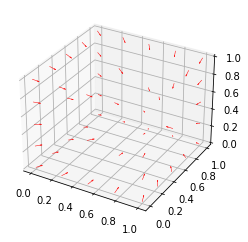

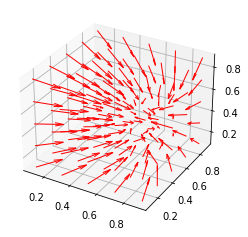

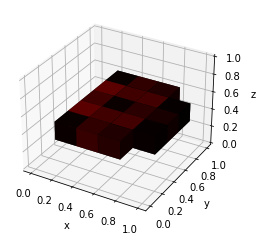

maximum_volume 0.05 and number of voxels 125 --- 1.1298420429229736 seconds ---


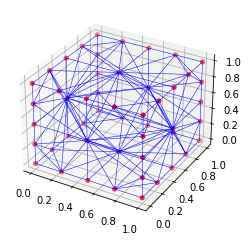

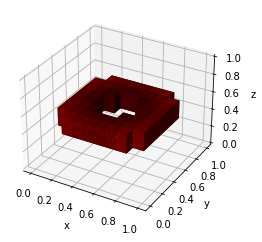

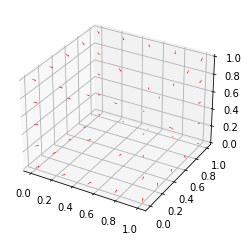

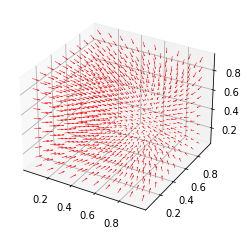

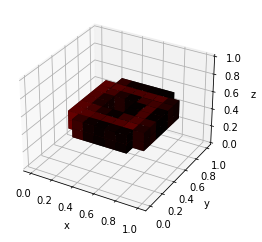

maximum_volume 0.05 and number of voxels 1000 --- 12.159259796142578 seconds ---


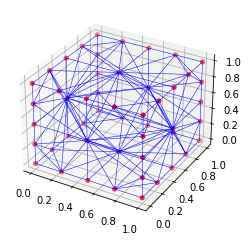

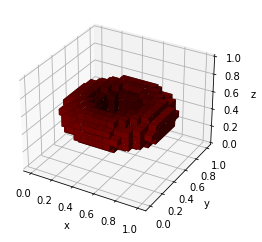

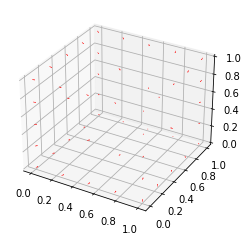

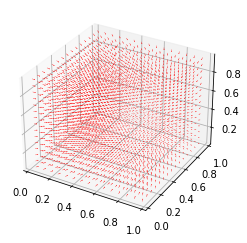

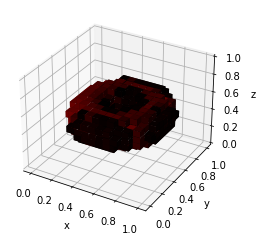

maximum_volume 0.05 and number of voxels 3375 --- 111.07103037834167 seconds ---


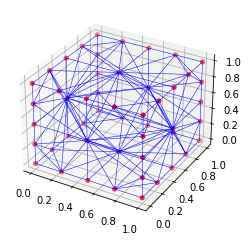

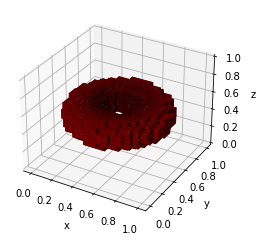

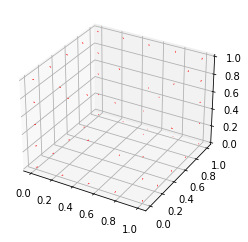

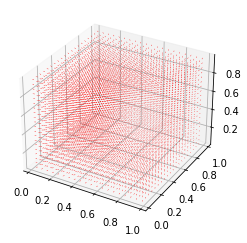

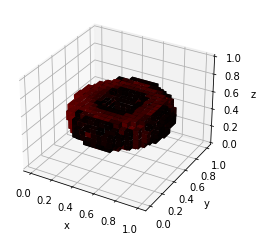

maximum_volume 0.05 and number of voxels 8000 --- 567.5971057415009 seconds ---


In [40]:
import time
import numpy as np
for maximum_volume in [0.2, 0.1, 0.05]:
    for N in [5, 10, 15, 20]:
        start_time = time.time()
        E, P = unit_cubic_mesh(maximum_volume)
        X,Y,Z,x,y,z = voxels_coordinates(N)
        torus, V = torus_density_map(X,Y,Z,x,y,z)
        fvectors = rigid_flow(P, N)
        voxels, indices = associate_voxel_with_TetraE(x,y,z)
        M0, voxels_v0 = flow_fields(voxels, indices, P, E, fvectors)
        W1 = deformed_density_map(X, Y, Z, torus, voxels_v0, V, 'simple', N)
        print("maximum_volume %s and number of voxels %s --- %s seconds ---" % (maximum_volume, N**3, time.time() - start_time))
        

The time table is listed below:

| N\\maximum\_volume | 0.2        | 0.1        | 0.05       |
| ------------------ | ---------- | ---------- | ---------- |
| 5                  | 1.00503945 | 1.29203701 | 1.12984204 |
| 10                 | 19.0572076 | 11.8662851 | 12.1592598 |
| 15                 | 103.547183 | 107.224411 | 111.07103  |
| 20                 | 591.83936  | 604.311383 | 567.597106 |

It is clear that maximum_volume contributes little to the total time consumed while the number of voxels affects heavily. The estimated order of $N$ is $O(4.5)$

time complexity in terms of N is approximately big O of N^ 4.506275998487805


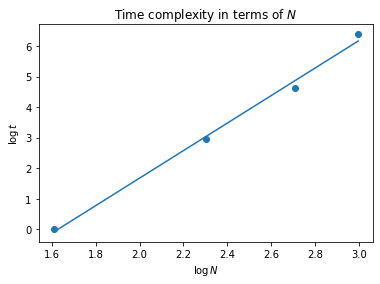

In [54]:
import numpy as np
import matplotlib.pyplot as plt


def best_fit_line(x_values, y_values):
    """Returns slope and y-intercept of the best fit line of the values"""

    mean = lambda l: sum(l)/len(l)
    multiply = lambda l1, l2: [a*b for a, b in zip(l1, l2)]

    m = ( (mean(x_values)*mean(y_values) - mean(multiply(x_values, y_values))) / 
          (mean(x_values)**2             - mean(multiply(x_values, x_values))) )

    b = mean(y_values) - m*mean(x_values)

    return m, b;

data = np.array([[5, 1.00503945], [10, 19.0572076], [15, 103.547183], [20, 591.83936]])
x = np.log(data[:,0])
y = np.log(data[:,1])
m, b = best_fit_line(x, y)

print('time complexity in terms of N is approximately big O of N^',m)


plt.scatter(x, y) 
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.title('Time complexity in terms of $N$')
plt.xlabel(r'$\log  N$')
plt.ylabel(r'$\log t$')

plt.show()